In [ ]:
import os
path = "/content/drive/My Drive/Assignment3"
os.chdir(path)
os.listdir(path)

['randomizedSmoothingexample.py',
 'models',
 '__pycache__',
 'data',
 'model_CFAR10.h5',
 'networks.py',
 'testRamdomizedSmoothing.ipynb',
 'A3_ZFC.ipynb',
 'DS3.ipynb',
 'README.md',
 'requirements.txt',
 'test_project.py',
 'utils.py',
 'record1(fgsm,n=100).csv',
 'randomizedSmoothing.py',
 'model.py',
 'cifar-10-batches-py',
 'attacks.py',
 'record1(pgd,n=1000,eps=0.5,60).csv',
 'record1(pgd,n=1000,eps=0.5,10).csv',
 'record1(pgd,n=1000,eps=1,10).csv',
 'record1(pgd,n=1000,eps=0.1,10).csv',
 'record2(fgsm,n=1000).csv',
 'record3(fgsm,n=1000,eps=0.1,0.5,1).csv']

In [ ]:
import argparse
from numpy.lib.type_check import imag
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms

from utils import test_attack,imshow,classes,plot_accuracies
import attacks
import randomizedSmoothing
from model import Net, train_model, train_adversarial, test_natural, get_train_loader, get_validation_loader


In [ ]:
def smoothTraining(f,train_loader,pth_filename,num_epochs,sigma,num_class):
    print("Starting training")
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(f.parameters(),lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_noise = inputs + torch.randn_like(inputs)*sigma

            # foreward pass
            outputs = f(inputs_noise)
            loss = criterion(outputs,labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"epoch [{epoch+1}/{num_epochs}] --- loss : {loss.item():.6f}")
    f.save(pth_filename)
    print(f'Model saved in {pth_filename}')
    return f

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

valid_size = 1024 
batch_size = 64
n_epochs = 10
model_file="models/mobnetv2.pth" 
adv_model_file="models/adv_fgsm_mobnetv2.pth" 


# Main

In [ ]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1)

Training with Noise

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()]) 
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size=batch_size)

train_model(net, train_loader, model_file, num_epochs = 20)

Files already downloaded and verified
Starting training
epoch [1/20] --- loss : 0.696 --- acc : 0.503
epoch [2/20] --- loss : 1.597 --- acc : 0.676
epoch [3/20] --- loss : 0.966 --- acc : 0.749
epoch [4/20] --- loss : 0.932 --- acc : 0.792
epoch [5/20] --- loss : 0.417 --- acc : 0.820
epoch [6/20] --- loss : 0.612 --- acc : 0.843
epoch [7/20] --- loss : 0.172 --- acc : 0.865
epoch [8/20] --- loss : 0.290 --- acc : 0.881
epoch [9/20] --- loss : 0.733 --- acc : 0.896
epoch [10/20] --- loss : 0.234 --- acc : 0.910
epoch [11/20] --- loss : 0.367 --- acc : 0.921
epoch [12/20] --- loss : 0.476 --- acc : 0.926
epoch [13/20] --- loss : 0.768 --- acc : 0.940
epoch [14/20] --- loss : 0.166 --- acc : 0.942
epoch [15/20] --- loss : 0.196 --- acc : 0.948
epoch [16/20] --- loss : 0.020 --- acc : 0.953
epoch [17/20] --- loss : 0.041 --- acc : 0.957
epoch [18/20] --- loss : 0.671 --- acc : 0.962
epoch [19/20] --- loss : 0.095 --- acc : 0.959
epoch [20/20] --- loss : 0.109 --- acc : 0.966
Model saved i

In [ ]:
i = 1
acc_smth=0
while acc_smth < 80:
    smth_model_file="models/smooth_model_"+str(i)+".pth"
    net = smoothTraining(net,train_loader,smth_model_file,num_epochs=10,sigma = 0.5,num_class=10)
    valid_loader = get_validation_loader(cifar, valid_size)
    acc_smth = test_natural(net, valid_loader)
    i += 1


Starting training
epoch [1/10] --- loss : 1.364541
epoch [2/10] --- loss : 1.117114
epoch [3/10] --- loss : 1.639470
epoch [4/10] --- loss : 1.039822
epoch [5/10] --- loss : 1.023711
epoch [6/10] --- loss : 1.255353
epoch [7/10] --- loss : 1.262431
epoch [8/10] --- loss : 0.787373
epoch [9/10] --- loss : 1.209973
epoch [10/10] --- loss : 1.256904
Model saved in models/smooth_model_1.pth
Starting training
epoch [1/10] --- loss : 1.104576
epoch [2/10] --- loss : 0.936583
epoch [3/10] --- loss : 1.442775
epoch [4/10] --- loss : 0.786277
epoch [5/10] --- loss : 1.726039
epoch [6/10] --- loss : 0.839498
epoch [7/10] --- loss : 0.947941
epoch [8/10] --- loss : 0.865597
epoch [9/10] --- loss : 1.854169
epoch [10/10] --- loss : 1.065332
Model saved in models/smooth_model_2.pth
Starting training
epoch [1/10] --- loss : 0.824018
epoch [2/10] --- loss : 0.486121
epoch [3/10] --- loss : 0.755362
epoch [4/10] --- loss : 1.355402
epoch [5/10] --- loss : 0.974731
epoch [6/10] --- loss : 0.825938
epoc

KeyboardInterrupt: ignored

In [ ]:
net_orig = Net()
net_orig.to(device)
net_orig.load(model_file)

In [ ]:
net_smth = Net()
net_smth.to(device)
net_smth.load('./models/smooth_model_10.pth')

In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor()) 
valid_loader = get_validation_loader(cifar, valid_size)
acc_orig = test_natural(net_orig, valid_loader)
acc_smth = test_natural(net_smth, valid_loader)
print("Model(orignal) natural accuracy (valid): {}".format(acc_orig))
print("Model(base, smooth) natural accuracy (valid): {}".format(acc_smth))

Files already downloaded and verified
Model(orignal) natural accuracy (valid): 81.93359375
Model(base, smooth) natural accuracy (valid): 66.50390625


## FGSM Attack

In [ ]:
!pip install cleverhans

In [ ]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

n=1000

In [ ]:
criterion = nn.NLLLoss()
epss = [0.03]
sigmas = [0.1,0.25,0.5,1,2]
correct_natural = 0
correct_smoothing = 0
nb_abstain = 0
total = 0
record = {'eps':[],'sigma':[],'acc_natural':[],'acc_smoothing':[],'rate_abstain':[]}

for sigma in sigmas:
  for eps in epss:
    print('sigma: {}'.format(sigma))
    print('eps: {}'.format(eps))
    record['sigma'].append(sigma)
    record['eps'].append(eps)
    for i, data in enumerate(valid_loader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)
      attacked_images = attacks.fgsm_attack(net_orig,criterion,images,labels,eps=eps)
      with torch.no_grad():
        pred_natural = net_orig(attacked_images).argmax(dim = 1)
        correct_natural += (pred_natural == labels).sum().item()
        
        for j in range(len(images)):
          x = attacked_images[j]
          y = labels[j]
          pred_smoothing = randomizedSmoothing.smoothPredict(net_smth, sigma = sigma, x = x, n = 1000, alpha = 0.01, num_class = 10)
          if pred_smoothing == -1:
            nb_abstain += 1
          elif torch.tensor(pred_smoothing).to(device) == y:
            correct_smoothing += 1
        
        total += labels.size(0)

    acc_natural = 100 * correct_natural / total
    acc_smoothing = 100 * correct_smoothing / total
    rate_abstain = 100 * nb_abstain / total
    record['acc_natural'].append(acc_natural)
    record['acc_smoothing'].append(acc_smoothing)
    record['rate_abstain'].append(rate_abstain)
    print("Base model accuracy (under fgsm attack): {}".format(acc_natural))
    print("Smoothing model accuracy (under fgsm attack): {}".format(acc_smoothing))
    print("Smoothing model abstain rate (under fgsm attack): {}".format(rate_abstain))

import pandas as pd
df = pd.DataFrame.from_dict(record)
df.to_csv('record2(fgsm,n=1000).csv')


sigma: 0.1
eps: 0.03
Base model accuracy (under fgsm attack): 47.65625
Smoothing model accuracy (under fgsm attack): 67.28515625
Smoothing model abstain rate (under fgsm attack): 1.5625
sigma: 0.25
eps: 0.03
Base model accuracy (under fgsm attack): 46.728515625
Smoothing model accuracy (under fgsm attack): 67.236328125
Smoothing model abstain rate (under fgsm attack): 3.02734375
sigma: 0.5
eps: 0.03
Base model accuracy (under fgsm attack): 46.38671875
Smoothing model accuracy (under fgsm attack): 61.848958333333336
Smoothing model abstain rate (under fgsm attack): 4.231770833333333
sigma: 1
eps: 0.03
Base model accuracy (under fgsm attack): 45.8740234375
Smoothing model accuracy (under fgsm attack): 51.3427734375
Smoothing model abstain rate (under fgsm attack): 5.7373046875
sigma: 2
eps: 0.03
Base model accuracy (under fgsm attack): 46.1328125
Smoothing model accuracy (under fgsm attack): 43.359375
Smoothing model abstain rate (under fgsm attack): 5.703125


In [ ]:

criterion = nn.NLLLoss()
epss = [0.1,0.5,1]
sigmas = [0.1,0.25,0.5,1,2]
correct_natural = 0
correct_smoothing = 0
nb_abstain = 0
total = 0
record = {'eps':[],'sigma':[],'acc_natural':[],'acc_smoothing':[],'rate_abstain':[]}

for sigma in sigmas:
  for eps in epss:
    print('sigma: {}'.format(sigma))
    print('eps: {}'.format(eps))
    record['sigma'].append(sigma)
    record['eps'].append(eps)
    for i, data in enumerate(valid_loader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)
      attacked_images = fast_gradient_method(net_orig,images,eps,norm = np.inf)
      # attacked_images = attacks.fgsm_attack(net_orig,criterion,images,labels,eps=eps)
      with torch.no_grad():
        pred_natural = net_orig(attacked_images).argmax(dim = 1)
        correct_natural += (pred_natural == labels).sum().item()
        
        for j in range(len(images)):
          x = attacked_images[j]
          y = labels[j]
          pred_smoothing = randomizedSmoothing.smoothPredict(net_smth, sigma = sigma, x = x, n = 1000, alpha = 0.01, num_class = 10)
          if pred_smoothing == -1:
            nb_abstain += 1
          elif torch.tensor(pred_smoothing).to(device) == y:
            correct_smoothing += 1
        
        total += labels.size(0)

    acc_natural = 100 * correct_natural / total
    acc_smoothing = 100 * correct_smoothing / total
    rate_abstain = 100 * nb_abstain / total
    record['acc_natural'].append(acc_natural)
    record['acc_smoothing'].append(acc_smoothing)
    record['rate_abstain'].append(rate_abstain)
    print("Base model accuracy (under fgsm attack): {}".format(acc_natural))
    print("Smoothing model accuracy (under fgsm attack): {}".format(acc_smoothing))
    print("Smoothing model abstain rate (under fgsm attack): {}".format(rate_abstain))

    import pandas as pd
    df = pd.DataFrame.from_dict(record)
    df.to_csv('record3(fgsm,n=1000,eps=0.1,0.5,1).csv')


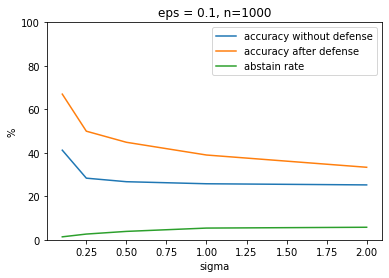

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('record3(fgsm,n=1000,eps=0.1,0.5,1).csv')
df.head()

eps = 0.1

plt.figure()
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_natural'],label = 'accuracy without defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_smoothing'],label = 'accuracy after defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['rate_abstain'],label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 0.1, n=1000')
plt.show()



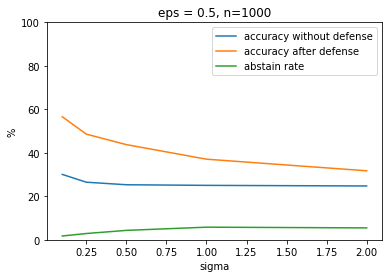

In [ ]:
eps = 0.5

plt.figure()
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_natural'],label = 'accuracy without defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_smoothing'],label = 'accuracy after defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['rate_abstain'],label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 0.5, n=1000')
plt.show()

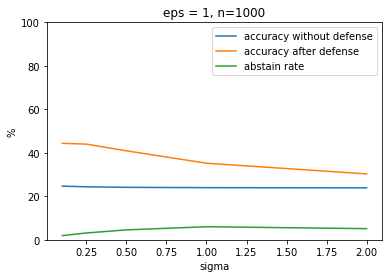

In [ ]:
eps = 1

plt.figure()
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_natural'],label = 'accuracy without defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['acc_smoothing'],label = 'accuracy after defense')
plt.plot(df[df['eps']==eps]['sigma'],df[df['eps']==eps]['rate_abstain'],label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 1, n=1000')
plt.show()

## PGD attack

In [ ]:
!pip install cleverhans

In [ ]:
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [ ]:
criterion = nn.NLLLoss()
epss = [0.5]
sigmas = [0.1,0.25,0.5,1,2]
correct_natural = 0
correct_smoothing = 0
nb_abstain = 0
total = 0
record = {'eps':[],'sigma':[],'acc_natural':[],'acc_smoothing':[],'rate_abstain':[]}


for sigma in sigmas:
  for eps in epss:
    print('==========================================')
    print('sigma: {}'.format(sigma))
    print('eps: {}'.format(eps))
    record['sigma'].append(sigma)
    record['eps'].append(eps)
    for i, data in enumerate(valid_loader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)
      attacked_images = projected_gradient_descent(net_orig, images, eps, eps_iter = 0.1, nb_iter = 20, norm = 2)
      with torch.no_grad():
        pred_natural = net_orig(attacked_images).argmax(dim = 1)
        correct_natural += (pred_natural == labels).sum().item()
        
        for j in range(len(images)):
          x = attacked_images[j]
          y = labels[j]
          pred_smoothing = randomizedSmoothing.smoothPredict(net_smth, sigma, x = x, n = 1000, alpha = 0.01, num_class = 10)
          if pred_smoothing == -1:
            nb_abstain += 1
          elif torch.tensor(pred_smoothing).to(device) == y:
            correct_smoothing += 1
        
        total += labels.size(0)

    acc_natural = 100 * correct_natural / total
    acc_smoothing = 100 * correct_smoothing / total
    rate_abstain = 100 * nb_abstain / total
    record['acc_natural'].append(acc_natural)
    record['acc_smoothing'].append(acc_smoothing)
    record['rate_abstain'].append(rate_abstain)

    print("Base model accuracy (under pgd attack): {}".format(acc_natural))
    print("Smoothing model accuracy (under pgd attack): {}".format(acc_smoothing))
    print("Smoothing model abstain rate (under pgd attack): {}".format(rate_abstain))

    import pandas as pd
    df = pd.DataFrame.from_dict(record)
    df.to_csv('record1(pgd,n=1000,eps=0.5,10).csv')



sigma: 0.1
eps: 0.5
Base model accuracy (under pgd attack): 15.33203125
Smoothing model accuracy (under pgd attack): 67.7734375
Smoothing model abstain rate (under pgd attack): 1.7578125
sigma: 0.25
eps: 0.5
Base model accuracy (under pgd attack): 15.185546875
Smoothing model accuracy (under pgd attack): 67.431640625
Smoothing model abstain rate (under pgd attack): 2.83203125
sigma: 0.5
eps: 0.5
Base model accuracy (under pgd attack): 14.811197916666666
Smoothing model accuracy (under pgd attack): 61.979166666666664
Smoothing model abstain rate (under pgd attack): 4.459635416666667
sigma: 1
eps: 0.5
Base model accuracy (under pgd attack): 14.74609375
Smoothing model accuracy (under pgd attack): 51.8798828125
Smoothing model abstain rate (under pgd attack): 6.396484375
sigma: 2
eps: 0.5
Base model accuracy (under pgd attack): 14.53125
Smoothing model accuracy (under pgd attack): 43.7109375
Smoothing model abstain rate (under pgd attack): 5.8203125


In [ ]:
criterion = nn.NLLLoss()
epss = [1]
sigmas = [0.1,0.25,0.5,1,2]
correct_natural = 0
correct_smoothing = 0
nb_abstain = 0
total = 0
record = {'eps':[],'sigma':[],'acc_natural':[],'acc_smoothing':[],'rate_abstain':[]}


for sigma in sigmas:
  for eps in epss:
    print('==========================================')
    print('sigma: {}'.format(sigma))
    print('eps: {}'.format(eps))
    record['sigma'].append(sigma)
    record['eps'].append(eps)
    for i, data in enumerate(valid_loader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)
      attacked_images = projected_gradient_descent(net_orig, images, eps, eps_iter = 0.1, nb_iter = 20, norm = 2)
      with torch.no_grad():
        pred_natural = net_orig(attacked_images).argmax(dim = 1)
        correct_natural += (pred_natural == labels).sum().item()
        
        for j in range(len(images)):
          x = attacked_images[j]
          y = labels[j]
          pred_smoothing = randomizedSmoothing.smoothPredict(net_smth, sigma, x = x, n = 1000, alpha = 0.01, num_class = 10)
          if pred_smoothing == -1:
            nb_abstain += 1
          elif torch.tensor(pred_smoothing).to(device) == y:
            correct_smoothing += 1
        
        total += labels.size(0)

    acc_natural = 100 * correct_natural / total
    acc_smoothing = 100 * correct_smoothing / total
    rate_abstain = 100 * nb_abstain / total
    record['acc_natural'].append(acc_natural)
    record['acc_smoothing'].append(acc_smoothing)
    record['rate_abstain'].append(rate_abstain)

    print("Base model accuracy (under pgd attack): {}".format(acc_natural))
    print("Smoothing model accuracy (under pgd attack): {}".format(acc_smoothing))
    print("Smoothing model abstain rate (under pgd attack): {}".format(rate_abstain))

    import pandas as pd
    df = pd.DataFrame.from_dict(record)
    df.to_csv('record1(pgd,n=1000,eps=1,10).csv')



sigma: 0.1
eps: 1
Base model accuracy (under pgd attack): 9.08203125
Smoothing model accuracy (under pgd attack): 67.28515625
Smoothing model abstain rate (under pgd attack): 2.1484375
sigma: 0.25
eps: 1
Base model accuracy (under pgd attack): 9.716796875
Smoothing model accuracy (under pgd attack): 67.138671875
Smoothing model abstain rate (under pgd attack): 3.173828125
sigma: 0.5
eps: 1
Base model accuracy (under pgd attack): 9.5703125
Smoothing model accuracy (under pgd attack): 61.783854166666664
Smoothing model abstain rate (under pgd attack): 4.361979166666667
sigma: 1
eps: 1
Base model accuracy (under pgd attack): 9.2041015625
Smoothing model accuracy (under pgd attack): 51.7333984375
Smoothing model abstain rate (under pgd attack): 6.4697265625
sigma: 2
eps: 1
Base model accuracy (under pgd attack): 9.35546875
Smoothing model accuracy (under pgd attack): 43.59375
Smoothing model abstain rate (under pgd attack): 5.87890625


In [ ]:
criterion = nn.NLLLoss()
epss = [0.1]
sigmas = [0.1,0.25,0.5,1,2]
correct_natural = 0
correct_smoothing = 0
nb_abstain = 0
total = 0
record = {'eps':[],'sigma':[],'acc_natural':[],'acc_smoothing':[],'rate_abstain':[]}


for sigma in sigmas:
  for eps in epss:
    print('==========================================')
    print('sigma: {}'.format(sigma))
    print('eps: {}'.format(eps))
    record['sigma'].append(sigma)
    record['eps'].append(eps)
    for i, data in enumerate(valid_loader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)
      attacked_images = projected_gradient_descent(net_orig, images, eps, eps_iter = 0.1, nb_iter = 20, norm = 2)
      with torch.no_grad():
        pred_natural = net_orig(attacked_images).argmax(dim = 1)
        correct_natural += (pred_natural == labels).sum().item()
        
        for j in range(len(images)):
          x = attacked_images[j]
          y = labels[j]
          pred_smoothing = randomizedSmoothing.smoothPredict(net_smth, sigma, x = x, n = 1000, alpha = 0.01, num_class = 10)
          if pred_smoothing == -1:
            nb_abstain += 1
          elif torch.tensor(pred_smoothing).to(device) == y:
            correct_smoothing += 1
        
        total += labels.size(0)

    acc_natural = 100 * correct_natural / total
    acc_smoothing = 100 * correct_smoothing / total
    rate_abstain = 100 * nb_abstain / total
    record['acc_natural'].append(acc_natural)
    record['acc_smoothing'].append(acc_smoothing)
    record['rate_abstain'].append(rate_abstain)

    print("Base model accuracy (under pgd attack): {}".format(acc_natural))
    print("Smoothing model accuracy (under pgd attack): {}".format(acc_smoothing))
    print("Smoothing model abstain rate (under pgd attack): {}".format(rate_abstain))

    import pandas as pd
    df = pd.DataFrame.from_dict(record)
    df.to_csv('record1(pgd,n=1000,eps=0.1,10).csv')



sigma: 0.1
eps: 0.1
Base model accuracy (under pgd attack): 57.32421875
Smoothing model accuracy (under pgd attack): 67.67578125
Smoothing model abstain rate (under pgd attack): 1.7578125
sigma: 0.25
eps: 0.1
Base model accuracy (under pgd attack): 57.12890625
Smoothing model accuracy (under pgd attack): 67.822265625
Smoothing model abstain rate (under pgd attack): 2.83203125
sigma: 0.5
eps: 0.1
Base model accuracy (under pgd attack): 57.649739583333336
Smoothing model accuracy (under pgd attack): 62.3046875
Smoothing model abstain rate (under pgd attack): 4.036458333333333
sigma: 1
eps: 0.1
Base model accuracy (under pgd attack): 57.6416015625
Smoothing model accuracy (under pgd attack): 51.6357421875
Smoothing model abstain rate (under pgd attack): 5.615234375
sigma: 2
eps: 0.1
Base model accuracy (under pgd attack): 57.734375
Smoothing model accuracy (under pgd attack): 43.61328125
Smoothing model abstain rate (under pgd attack): 5.6640625


In [ ]:
df1 = pd.read_csv('record1(pgd,n=1000,eps=0.1,10).csv')

df2 = pd.read_csv('record1(pgd,n=1000,eps=0.5,10).csv')

df3 = pd.read_csv('record1(pgd,n=1000,eps=1,10).csv')

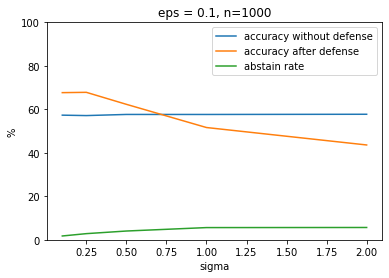

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df1['sigma'],df1['acc_natural'], label = 'accuracy without defense')
plt.plot(df1['sigma'],df1['acc_smoothing'], label = 'accuracy after defense')
plt.plot(df1['sigma'],df1['rate_abstain'], label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 0.1, n=1000')
plt.show()


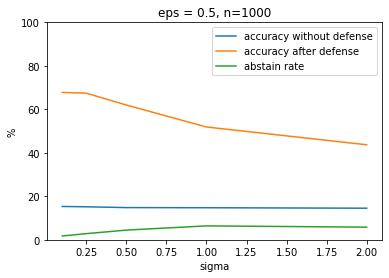

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df2['sigma'],df2['acc_natural'], label = 'accuracy without defense')
plt.plot(df2['sigma'],df2['acc_smoothing'], label = 'accuracy after defense')
plt.plot(df2['sigma'],df2['rate_abstain'], label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 0.5, n=1000')
plt.show()

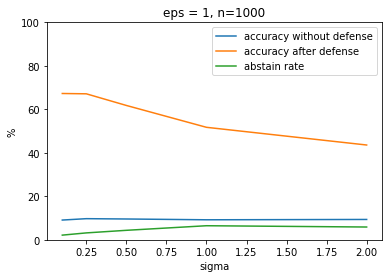

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df3['sigma'],df3['acc_natural'], label = 'accuracy without defense')
plt.plot(df3['sigma'],df3['acc_smoothing'], label = 'accuracy after defense')
plt.plot(df3['sigma'],df3['rate_abstain'], label = 'abstain rate')
plt.legend()
plt.ylim((0,100))
plt.xlabel('sigma')
plt.ylabel('%')
plt.title('eps = 1, n=1000')
plt.show()